In [ ]:
!pip install av
!pip install -qq --upgrade albumentations
!pip install -qq gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 45.8 MB/s eta 0:00:00


In [ ]:
# importar librerias necesarias
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import av
import albumentations as A
import gc
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, fbeta_score, roc_curve, auc
from fastai.callback.core import Callback
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# establecer semillas aleatorias para garantizar la reproducibilidad de los resultados
def seed_everything (seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    set_seed(random_seed, reproducible=True)

# Parámetros de pre-procesado

In [ ]:
# aplicar ajuste contraste True / False
use_bcet = False

# oversampling de clases minoritarias 0-30 (3) / 40-50 (4)
# numero de videos total por franja que queremos obtener con 0 no hay oversampling
oversampling_min = 0

# definir frame inicial y numero maximo
start_frame=0
max_frames=120

# 1. Extraer frames

In [ ]:
# descargar los datos, id oculto por privacidad
!gdown XXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
# descomprimir el zip
!unzip -qq data.zip -d tfm-data

mapname:  conversion of  failed


In [ ]:
# vamos a trabajar en el directorio en el que están los datos
%cd ./tfm-data

/content/tfm-data


In [ ]:
# usamos Path para acceder más fácilmente
data_path = Path('./videos')
data_path.ls()

(#1480) [Path('videos/0X1CD114B3DED2907A.avi'),Path('videos/0X2CE2BBE899FB30A.avi'),Path('videos/0X3C68A75B6DE0D08C.avi'),Path('videos/0X1F7984F85C024A44.avi'),Path('videos/0X3C67FDA7B1C1ECFB.avi'),Path('videos/0X2AB73E07EA2A8D7F.avi'),Path('videos/0X2C073A809964F995.avi'),Path('videos/0X2F3CE7185C80B272.avi'),Path('videos/0X1EE30D34D1CBF56A.avi'),Path('videos/0X1AD3CDEC841DA50.avi')...]

In [ ]:
# con get_files obtenemos referencias a los ficheros de los videos
video_paths = get_files(data_path, extensions='.avi')
video_paths[0:4]

(#4) [Path('videos/0X1CD114B3DED2907A.avi'),Path('videos/0X2CE2BBE899FB30A.avi'),Path('videos/0X3C68A75B6DE0D08C.avi'),Path('videos/0X1F7984F85C024A44.avi')]

In [ ]:
video_paths[0]

Path('videos/0X1CD114B3DED2907A.avi')

In [ ]:
# creamos un nuevo directorio para las frames
path_frames = Path('/content/tfm-data')/'frames'
if not path_frames.exists(): path_frames.mkdir()

In [ ]:
path_frames

Path('/content/tfm-data/frames')

In [ ]:
video_path = video_paths[0]
video_path.stem

'0X1CD114B3DED2907A'

In [ ]:
# Balanced Contrast Enhancement Technique (BCET). Esta función realiza la técnica de mejora de contraste equilibrado BCET en una imagen.
def bcet(image, ex=110, low=0, high=255):
    # Calcular el valor medio cuadrado de la imagen
    s = np.mean(np.power(image, 2)) # mean squared
    # Calcular el valor medio de la imagen
    e = np.mean(image)
    # Encontrar el valor mínimo y máximo de la imagen
    l = np.min(image)
    h = np.max(image)

    # Valores de salida personalizables
    L = low # valor mínimo de salida
    H = high # valor máximo de salida
    E = ex # valor medio de salida

    # Calcular el parámetro b
    b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
    b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))
    b = b_nom/b_den

    # Calcular el parámetro a
    a1 = H-L
    a2 = h-l
    a3 = h+l-(2*b)
    a = a1/(a2*a3)

    # Calcular el parámetro c
    c = L-(a*(l-b)**2)

    # Aplicar la técnica BCET para mejorar el contraste
    new_image = a*((image - b)**2) + c
    return new_image

In [ ]:
# función que extrae y salva frames de un video
def avi2frames(video_path, path_frames=path_frames, start_frame=start_frame, max_frames=max_frames):
    dest_path = path_frames/video_path.stem
    # creamos el directorio para guardar las frames
    dest_path.mkdir(parents=True, exist_ok=True)
    # abrimos el video
    video = av.open(str(video_path))
    # extraemos las frames y convertimos a escala de grises y aplicamos bcet
    frames = [frame.to_image().convert("L") for frame in video.decode(0)]
    # nos quedamos con max_frames, empezando en start_frame
    if len(frames) < (start_frame + max_frames):
      start_frame = max(0, len(frames) - max_frames)
    for i, frame in enumerate(frames[start_frame:(start_frame + max_frames)]):
        if use_bcet == True: # aplicamos ajuste de contraste
          frame = bcet(np.array(frame), low=0, ex=50, high=255)
        else:
          frame = np.array(frame)
        # guardamos cada frame, numerada, dentro del directorio del video
        cv2.imwrite(str(dest_path/f'{i}.png'), frame)

In [ ]:
# probamos que funciona correctamente
avi2frames(video_paths[100], start_frame=start_frame, max_frames=max_frames)
len(path_frames.ls()[0].ls())

120

In [ ]:
# ejecutamos para todas las frames
parallel(avi2frames, video_paths)

(#1480) [None,None,None,None,None,None,None,None,None,None...]

In [ ]:
# comprobamos que se han creado frames para los 1480 videos
len(path_frames.ls())

1480

In [ ]:
# comprobamos que se han extraido las frames que queriamos
len(path_frames.ls()[0].ls())

120

In [ ]:
# definimos una función que devuelva las frames ordenadas
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

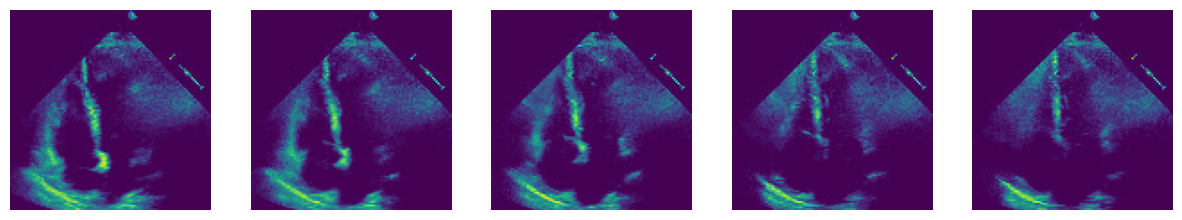

In [ ]:
# comprobamos que las imágenes se ven correctamente
show_images([Image.open(img) for img in path_frames.ls()[0].ls_sorted()[0:25:5]])

# 2. Cargar dataset y generar splits

In [ ]:
# cargamos el dataset con el FEVI por cada video
df = pd.read_csv('target.csv')
df.head()

,FileName,FEVI
0,0X1A030EFDD45062FA,44.485700
1,0X1A05829AEDF6C65,64.078050
2,0X1A05DFFFCAFB253B,65.143601
3,0X1A09BE7969DA1508,69.566347
4,0X1A0A263B22CCD966,65.454529


In [ ]:
# muestra información resumida del DataFrame 'df'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  1480 non-null   object 
 1   FEVI      1480 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.2+ KB


In [ ]:
# creamos una nueva columna llamada 'target' en el DataFrame 'df' al dividir la columna 'FEVI' por 100
df['target'] = df['FEVI'] / 100
df.head()

,FileName,FEVI,target
0,0X1A030EFDD45062FA,44.485700,0.444857
1,0X1A05829AEDF6C65,64.078050,0.640781
2,0X1A05DFFFCAFB253B,65.143601,0.651436
3,0X1A09BE7969DA1508,69.566347,0.695663
4,0X1A0A263B22CCD966,65.454529,0.654545


In [ ]:
# asignamos target 1 a pacientes con FEVI < 50 y 0 al resto
df['target'] = np.where(df['FEVI'] < 50, 1, 0)
df['target'].value_counts()

0    1151
1     329
Name: target, dtype: int64

In [ ]:
# creamos una nueva columna llamada 'FEVI10' en el DataFrame 'df' al dividir la columna 'FEVI' por 10
df['FEVI10'] = df['FEVI'] // 10
df['FEVI10'].value_counts()

6.0    632
5.0    466
4.0    134
3.0     93
2.0     82
7.0     49
1.0     17
8.0      4
0.0      3
Name: FEVI10, dtype: int64

In [ ]:
# reasignamos las franjas 0/1/2/3 en una unica franja numero 3
df.loc[df['FEVI10'] == 0, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 2, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 1, 'FEVI10'] = 3

# reasignamos 6/7/8 en una unica franja numero 6
df.loc[df['FEVI10'] == 8, 'FEVI10'] = 6
df.loc[df['FEVI10'] == 7, 'FEVI10'] = 6

df['FEVI10'].value_counts()

6.0    685
5.0    466
3.0    195
4.0    134
Name: FEVI10, dtype: int64

In [ ]:
split_counts = df['FEVI10'].value_counts() // 10
split_counts

6.0    68
5.0    46
3.0    19
4.0    13
Name: FEVI10, dtype: int64

In [ ]:
list(split_counts.items())

[(6.0, 68), (5.0, 46), (3.0, 19), (4.0, 13)]

In [ ]:
sum(split_counts)

146

In [ ]:
# establecemos la semilla aleatoria en 12 para garantizar la reproducibilidad
random_seed=12
seed_everything(random_seed)

In [ ]:
# creamos el split de test
test_idx = np.array([])
for k, count in list(split_counts.items()):
  test_idx = np.concatenate([test_idx, df[df['FEVI10'] == k].sample(count, random_state=random_seed).index], axis=0)

test_df = df.iloc[test_idx].sample(frac=1, random_state=random_seed).reset_index(drop=True)
test_df['FEVI10'].value_counts()

6.0    68
5.0    46
3.0    19
4.0    13
Name: FEVI10, dtype: int64

In [ ]:
# generamos train, sacando las filas que hemos dejado para test
train_df = df[~df.index.isin(test_idx)].sample(frac=1, random_state=random_seed).reset_index(drop=True)
train_df.shape

(1334, 4)

In [ ]:
# creamos el split de valid
valid_idx = np.array([])
for k, count in list(split_counts.items()):
  valid_idx = np.concatenate([valid_idx, train_df[train_df['FEVI10'] == k].sample(count, random_state=random_seed).index], axis=0)

splits = IndexSplitter(valid_idx)

In [ ]:
# calculamos el recuento de valores del split de validacion
train_df.iloc[valid_idx]['FEVI10'].value_counts()

6.0    68
5.0    46
3.0    19
4.0    13
Name: FEVI10, dtype: int64

In [ ]:
# calculamos el recuento de valores del split de train
train_df[~train_df.index.isin(valid_idx)]['FEVI10'].value_counts()

6.0    549
5.0    374
3.0    157
4.0    108
Name: FEVI10, dtype: int64

In [ ]:
# comprobamos el numero total de valores tanto de train,como validacion y test
len(test_idx) + len(valid_idx) + len(train_df[~train_df.index.isin(valid_idx)])

1480

# 3. Oversampling

In [ ]:
# vamos a hacer oversampling, generando nuevos videos
# solo a partir de datos de train, por eso excluimos valid
if oversampling_min > 0:
  tr_df = train_df[~train_df.index.isin(valid_idx)]
  counts = tr_df['FEVI10'].value_counts()
  print(counts)

In [ ]:
if oversampling_min > 0:

  # Definimos las transformaciones que vamos a aplicar al replicar las frames
  transform = A.Compose([
      A.RandomBrightnessContrast(brightness_limit=(-0.03,0.06), contrast_limit=(-0.03,0.06), p=1),
      A.OneOf([
        A.MedianBlur(blur_limit=(3,3), p=0.5),
        A.GaussNoise(p=0.5),
      ], p=0.25),
      A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=3, border_mode=cv2.BORDER_CONSTANT, p=1),
  ])

  new_df = pd.DataFrame()
  tot_img = 0
  seed_everything(random_seed)

  # número de imágenes que queremos por cada franja de FEVI10
  num_img = oversampling_min

  for k, img_count in counts.items():
      if img_count >= num_img:
          continue
      tmp_df = tr_df[tr_df['FEVI10'] == k].reset_index(drop=True)
      # cuantos nuevos videos vamos a generar para cada subclase
      num_new = num_img - img_count
      idx = 0

      print(f"Generating {num_new} videos for class {k}")

      while num_new > 0:
        row = tmp_df.iloc[idx]
        video_id = row['FileName']
        new_video_id = f"{video_id}_{new_df.shape[0]}"
        # creamos directorio para el nuevo video
        video_path = path_frames/new_video_id
        if not video_path.exists(): video_path.mkdir()

        print(f"Generating new video {new_video_id} / idx {idx} / class {k}")
        data = None
        for img_path in (path_frames/video_id).ls_sorted():
          new_img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
          # aplicamos una transformacion
          data = transform(image=new_img)
          new_img = data['image']
          new_img_path = (video_path/img_path.stem).with_suffix('.png')

          if not cv2.imwrite(str(new_img_path), new_img):
              print(f"error writing file {new_img_path}")
              break

        new_df = new_df.append({'FileName': new_video_id, 'target': row['target'], 'FEVI10': k }, ignore_index=True)
        # indice del siguiente video
        idx = (idx + 1) % img_count
        # actualizamos numero de videos restantes
        num_new -= 1

  # ahora tenemos que juntar el DF con los nuevos videos con el que teniamos ya con train + valid
  valid_filenames = train_df.iloc[valid_idx]['FileName'].values

  # primero guardar referencias de valid
  new_valid_idx = train_df[train_df['FileName'].isin(valid_filenames)].index
  train_df.iloc[new_valid_idx]['FEVI10'].value_counts()

  # ahora concatenamos el nuevo df con train
  train_df = pd.concat([train_df, new_df], axis=0).sample(frac=1, random_state=random_seed).reset_index(drop=True)

  # y ahora volvemos a recuperar los idx de valid
  train_df[train_df['FileName'].isin(valid_filenames)]['FEVI10'].value_counts()

  new_valid_idx = train_df[train_df['FileName'].isin(valid_filenames)].index
  train_df.iloc[new_valid_idx]['FEVI10'].value_counts()
  splits = IndexSplitter(new_valid_idx)

  print(train_df[~train_df.index.isin(new_valid_idx)]['FEVI10'].value_counts())

# 4. Definir modelo

In [ ]:
# esta clase nos permite manejar un conjunto de imágenes como una tupla
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs):
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

# esta clase obtiene las frames de un video y las devuelve en forma de tupla
class ImageTupleTfm(Transform):
    def __init__(self, start_frame=0, seq_len=20):
        store_attr()

    def encodes(self, path: Path):
        frames = path.ls_sorted()
        n_frames = len(frames)

        # nos quedamos con max_frames, empezando en start_frame
        if n_frames < (self.start_frame + self.seq_len):
          self.start_frame = max(0, n_frames - self.seq_len)

        # si no tenemos suficientes frames, replicamos
        if n_frames < self.seq_len:
          new_frames = self.seq_len - n_frames
          for n in range(0, new_frames):
            frames.append(frames[n % n_frames])

        s = slice(self.start_frame, self.start_frame + self.seq_len)
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
# Esta función le dice al dataset donde buscar las X (frames de los videos)
def get_x(row): return path_frames/row['FileName']
# Y esta le dice donde buscar la Y, el target de cada X
def get_y(row): return row['target']

In [ ]:
video_frames_path = path_frames.ls()[10]
len(video_frames_path.ls_sorted())

120

In [ ]:
# comprobamos que funciona, deberia darnos 120 frames
tpl = ImageTupleTfm(seq_len=120)
len(tpl(video_frames_path))

120

# Training loop

In [ ]:
# definimos el grid de parametros

start_frame=[0]
#start_frame = np.arange(0, 40, 10)

seq_len=[40]
#start_frame = np.arange(10, 90, 10)

batch_augmentation = False # False / True

#dropout = np.arange(0, 1, 0.10)
dropout = [0.40]

# arquitectura de modelo que vamos a usar
model_arch = resnet18

# vamos a entrenar solo 20 sin unfreeze
epochs_freeze = 20

# batch size
bs = 8

In [ ]:
# definimos transformaciones para batch augmentation
batch_transforms = []

if batch_augmentation == True:
  batch_transforms = [
      Brightness(max_lighting=0.05, p=0.75),
      Contrast(max_lighting=0.05, p=0.75),
      Rotate(max_deg=3, p=0.5)
  ]

In [ ]:
# creamos un nuevo DataFrame vacío llamado 'results'
results = pd.DataFrame()



start_frame: 0; seq_len: 40; dropout: 0.4; model: <function resnet18 at 0x7e13dd799360>;


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


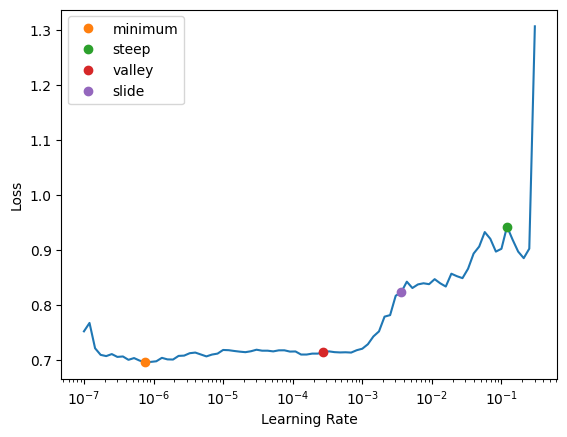

LR: 0.0002754228771664202


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,roc_auc_score,fbeta_score,time
0,0.658061,0.702935,0.527397,0.812500,0.292135,0.729441,0.599078,01:09
1,0.614840,0.710031,0.609589,0.687500,0.318841,0.723958,0.558376,01:11
2,0.582205,0.518626,0.760274,0.656250,0.466667,0.776727,0.606936,01:10
3,0.496805,0.420304,0.856164,0.593750,0.703704,0.809759,0.612903,01:09
4,0.423884,0.395492,0.828767,0.656250,0.600000,0.858553,0.644172,01:09
5,0.345733,0.353990,0.869863,0.718750,0.696970,0.858416,0.714286,01:09
6,0.270701,0.422338,0.773973,0.781250,0.490196,0.890214,0.698324,01:08
7,0.229863,0.403636,0.821918,0.718750,0.575000,0.858553,0.684524,01:07
8,0.184292,0.390516,0.869863,0.687500,0.709677,0.881579,0.691824,01:07
9,0.147553,0.511845,0.815068,0.843750,0.551020,0.885143,0.762712,01:08


Better model found at epoch 0 with fbeta_score value: 0.599078341013825.
Better model found at epoch 2 with fbeta_score value: 0.6069364161849711.
Better model found at epoch 3 with fbeta_score value: 0.6129032258064515.
Better model found at epoch 4 with fbeta_score value: 0.6441717791411044.
Better model found at epoch 5 with fbeta_score value: 0.7142857142857143.
Better model found at epoch 9 with fbeta_score value: 0.7627118644067797.
Better model found at epoch 12 with fbeta_score value: 0.778443113772455.
Better model found at epoch 13 with fbeta_score value: 0.8241758241758241.


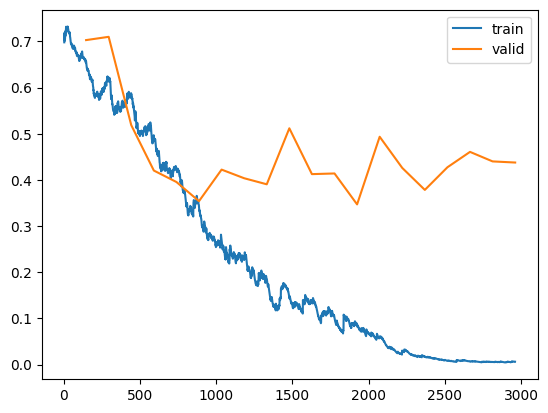

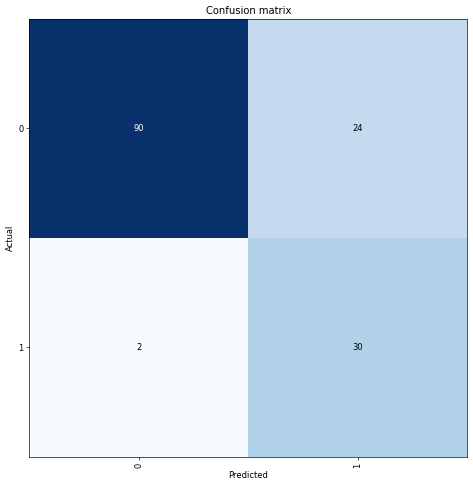

  model_arch   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  seq_len  valid_acc  valid_auc  valid_f2  \
0           8            0       40   0.821918   0.912281  0.824176   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.555556        0.9375  0.821918  0.910636  0.767045   

   test_precision  test_recall  
0          0.5625      0.84375  

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.347826
6.0    0.117647
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.307692
5.0    0.260870
6.0    0.132353
Name: FEVI10, dtype: float64


In [ ]:
for sf in start_frame:
  for sq in seq_len:
    for do in dropout:
      print("\n\n=========================")
      print(f"start_frame: {sf}; seq_len: {sq}; dropout: {do}; model: {model_arch};")
      seed_everything(random_seed)

      # creamos dataloader a partir del dataset
      # definimos dataset a partir del dataframe
      ds = Datasets(train_df,
                  tfms=[[get_x, ImageTupleTfm(seq_len=sq, start_frame=sf)],
                        [get_y, Categorize]],
                  splits=splits(train_df))

      # defininimos una clase llamada 'ClassificationModel' que se utiliza para crear un modelo de clasificación personalizado
      class ClassificationModel(Module):
          def __init__(self, model):
            # capa encoder que aplica 'create_body(model)' a cada paso de tiempo (TimeDistributed)
            self.encoder = TimeDistributed(create_body(model))
            # capa de dropout con el valor 'do'.
            self.dropout = nn.Dropout(do)
            # capa head que aplica 'create_head' al número de características de la capa fc de 'model' con 2 clases
            self.head = TimeDistributed(create_head(model.fc.in_features, 2))

          def forward(self, x):
            # apilamos los tensores en 'x' a lo largo de la dimensión 1
            x = torch.stack(x, dim=1)
            # aplicamos dropout a la salida del encoder
            x = self.dropout(self.encoder(x))
            return self.head(x).mean(dim=1)

      # definimos la función 'simple_splitter' que separa los parámetros de encoder y head del modelo
      def simple_splitter(model): return [params(model.encoder), params(model.head)]

      # creamos un conjunto de dataloaders (dls) a partir del dataset (ds)
      dls = ds.dataloaders(bs=bs, after_item=[Resize(112), ToTensor],
                     after_batch=[IntToFloatTensor, *batch_transforms, Normalize.from_stats(*imagenet_stats)])

      # creamos un modelo utilizando la clase 'ClassificationModel' con arquitectura preentrenada
      model = ClassificationModel(model_arch(pretrained=True)).cuda()

      # creamos un objeto 'learn' que utiliza el modelo y dataloaders y configura métricas y el splitter
      learn = Learner(dls, model,
                metrics=[accuracy, Recall(), Precision(), RocAucBinary(), FBeta(beta=2, average='binary')],
                splitter=simple_splitter).to_fp16()

      # realiza una búsqueda de la tasa de aprendizaje (LR) utilizando el método lr_find
      lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
      lr = lrs.valley
      plt.show()

      print(f"LR: {lr}")

      # definimos una lista de callbacks (cbs) que contiene un callback para guardar el mejor modelo basado en 'fbeta_score'
      cbs = [
            SaveModelCallback(monitor='fbeta_score', fname="best-fbeta", every_epoch=False, reset_on_fit=False)
      ]

      # entrenamos el modelo durante 'epochs_freeze' épocas utilizando el método 'fit_one_cycle' con los callbacks definidos
      learn.fit_one_cycle(epochs_freeze, lr, cbs=cbs)
      learn.recorder.plot_loss()
      plt.show()

      # cargamos el modelo con el mejor rendimiento en términos de 'fbeta_score'
      learn.load("best-fbeta")

      # calculamos la matriz de confusión
      interp = ClassificationInterpretation.from_learner(learn)
      interp.plot_confusion_matrix(figsize=(8, 8), dpi=60)
      plt.show()

      # obtenemos las predicciones (preds) y los objetivos reales (targets) utilizando el método 'get_preds'
      preds, targets = learn.get_preds()
      # calculamos las clases predichas tomando el índice del valor máximo en las predicciones (preds)
      predicted_classes = preds.argmax(dim=1)

      # calculamos las métricas en el conjunto de validación
      targets = targets.cpu()
      valid_acc = accuracy_score(targets, predicted_classes)
      valid_f2 = fbeta_score(targets, predicted_classes, beta=2, average='binary')
      valid_auc = roc_auc_score(targets, preds.cpu()[:, 1])
      valid_recall = recall_score(targets, predicted_classes)
      valid_precision = precision_score(targets, predicted_classes)
      valid_df = train_df.iloc[valid_idx].copy()
      valid_df['predicted'] = predicted_classes

      # preparamos el conjunto de test
      test_df = df.iloc[test_idx].copy().reset_index(drop=True)
      test_data = dls.test_dl(test_df)
      preds, _ = learn.tta(dl=test_data)
      predicted_classes = np.argmax(preds, axis=1)
      targets = test_df['target']

      # calculamos las métricas en el conjunto de test
      test_acc = accuracy_score(targets, predicted_classes)
      test_f2 = fbeta_score(targets, predicted_classes, beta=2, average='binary')
      test_auc = roc_auc_score(targets, preds.cpu()[:, 1])
      test_recall = recall_score(targets, predicted_classes)
      test_precision = precision_score(targets, predicted_classes)
      test_df['predicted'] = predicted_classes

      # creamos un DataFrame temporal (tmp_df) con el resumen de resultados
      tmp_df = pd.DataFrame([{
        "model_arch": model_arch.__name__, "bcet": use_bcet, "batch_aug": batch_augmentation, "dropout": do, "oversmp": oversampling_min,
        "epochs": epochs_freeze, "lr": lr, "batch_size": bs, "start_frame": sf, "seq_len": sq,
        "valid_acc": valid_acc, "valid_auc": valid_auc, "valid_f2": valid_f2, "valid_precision": valid_precision, "valid_recall": valid_recall,
        "test_acc": test_acc, "test_auc": test_auc, "test_f2": test_f2, "test_precision": test_precision, "test_recall": test_recall
      }])

      results = pd.concat([results, tmp_df], axis=0)

      print(tmp_df)
      print("\nValid - % errores por banda de FEVI")
      print(valid_df[valid_df['target'] != valid_df['predicted']]['FEVI10'].value_counts() / valid_df['FEVI10'].value_counts())

      print("\nTest - % errores por banda de FEVI")
      print(test_df[test_df['target'] != test_df['predicted']]['FEVI10'].value_counts() / test_df['FEVI10'].value_counts())

      gc.collect()
      torch.cuda.empty_cache()

# Resultados

In [ ]:
# ordenamos resultados para ver que parametros nos da mejores resultados
results.sort_values('test_f2', ascending=True).head(30)

,model_arch,bcet,batch_aug,dropout,oversmp,epochs,lr,batch_size,start_frame,seq_len,valid_acc,valid_auc,valid_f2,valid_precision,valid_recall,test_acc,test_auc,test_f2,test_precision,test_recall
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,0.821918,0.912281,0.824176,0.555556,0.9375,0.821918,0.910636,0.767045,0.5625,0.84375


In [ ]:
# guardamos en un archivo csv los resultados
results.to_csv("classification_grid-search_best2_v2.csv")

In [ ]:
results.to_excel("classification_gs_best2.xlsx")

In [ ]:
# definimos el grid de valores del umbral de decision desde 0 a 0.95 en multiplos de 0.05
thresh_values = np.arange(0, 1, 0.05)

In [ ]:
# aplicamos la busqueda en rejilla segun los valores definidos para el umbral de decision
for thresh in thresh_values:

    preds, targets = learn.get_preds()
    predicted_classes = (preds[:, 1] >= thresh).int()

    targets = targets.cpu()
    valid_acc = accuracy_score(targets, predicted_classes)
    valid_f2 = fbeta_score(targets, predicted_classes, beta=2, average='binary')
    valid_auc = roc_auc_score(targets, preds.cpu()[:, 1])
    valid_recall = recall_score(targets, predicted_classes)
    valid_precision = precision_score(targets, predicted_classes)
    valid_df = train_df.iloc[valid_idx].copy()
    valid_df['predicted'] = predicted_classes

    test_df = df.iloc[test_idx].copy().reset_index(drop=True)
    test_data = dls.test_dl(test_df)
    preds, _ = learn.tta(dl=test_data)
    predicted_classes = np.argmax((preds >= thresh).numpy().astype(np.int), axis=1)
    targets = test_df['target']
    test_acc = accuracy_score(targets, predicted_classes)
    test_f2 = fbeta_score(targets, predicted_classes, beta=2, average='binary')
    test_auc = roc_auc_score(targets, preds.cpu()[:, 1])
    test_recall = recall_score(targets, predicted_classes)
    test_precision = precision_score(targets, predicted_classes)
    test_df['predicted'] = predicted_classes

    tmp_df = pd.DataFrame([{
      "model_arch": model_arch.__name__, "threshold": thresh, "bcet": use_bcet, "batch_aug": batch_augmentation, "dropout": do, "oversmp": oversampling_min,
      "epochs": epochs_freeze, "lr": lr, "batch_size": bs, "start_frame": sf, "seq_len": sq,
      "valid_acc": valid_acc, "valid_auc": valid_auc, "valid_f2": valid_f2, "valid_precision": valid_precision, "valid_recall": valid_recall,
      "test_acc": test_acc, "test_auc": test_auc, "test_f2": test_f2, "test_precision": test_precision, "test_recall": test_recall
    }])

    results = pd.concat([results, tmp_df], axis=0)

    print(tmp_df)
    print("\nValid - % errores por banda de FEVI")
    print(valid_df[valid_df['target'] != valid_df['predicted']]['FEVI10'].value_counts() / valid_df['FEVI10'].value_counts())

    print("\nTest - % errores por banda de FEVI")
    print(test_df[test_df['target'] != test_df['predicted']]['FEVI10'].value_counts() / test_df['FEVI10'].value_counts())

    gc.collect()
    torch.cuda.empty_cache()

  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.0  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.219178   0.912281  0.583942   

   valid_precision  valid_recall  test_acc  test_auc  test_f2  test_precision  \
0         0.219178           1.0  0.780822  0.910636      0.0             0.0   

   test_recall  
0          0.0  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0    NaN
4.0    NaN
5.0    1.0
6.0    1.0
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    1.0
4.0    1.0
5.0    NaN
6.0    NaN
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.05  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.623288   0.912281    0.7109   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.361446        0.9375  0.883562  0.910636  0.629139   

   test_precision  test_recall  
0        0.826087      0.59375  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.565217
6.0    0.397059
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.157895
4.0    0.769231
5.0    0.086957
6.0         NaN
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.1  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.691781   0.912281  0.746269   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.410959        0.9375   0.89726  0.910636  0.709677   

   test_precision  test_recall  
0        0.814815       0.6875  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.478261
6.0    0.308824
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.157895
4.0    0.538462
5.0    0.086957
6.0    0.014706
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.15  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.712329   0.912281  0.757576   

   valid_precision  valid_recall  test_acc  test_auc  test_f2  test_precision  \
0         0.428571        0.9375  0.890411  0.910636     0.75            0.75   

   test_recall  
0         0.75  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.456522
6.0    0.279412
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.461538
5.0    0.152174
6.0    0.014706
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.2  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.732877   0.912281  0.769231   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.447761        0.9375  0.869863  0.910636  0.736196   

   test_precision  test_recall  
0        0.685714         0.75  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.456522
6.0    0.235294
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.461538
5.0    0.173913
6.0    0.044118
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.25  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.760274   0.912281   0.78534   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0          0.47619        0.9375  0.856164  0.910636  0.727273   

   test_precision  test_recall  
0        0.648649         0.75  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.413043
6.0    0.205882
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.461538
5.0    0.173913
6.0    0.073529
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.3  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.780822   0.912281  0.797872   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0              0.5        0.9375  0.856164  0.910636  0.748503   

   test_precision  test_recall  
0        0.641026      0.78125  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.391304
6.0    0.176471
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.384615
5.0    0.195652
6.0    0.073529
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.35  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.794521   0.912281  0.806452   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.517241        0.9375  0.849315  0.910636  0.764706   

   test_precision  test_recall  
0        0.619048       0.8125  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.369565
6.0    0.161765
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.384615
5.0    0.217391
6.0    0.088235
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.4  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.794521   0.912281  0.806452   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.517241        0.9375  0.842466  0.910636  0.760234   

   test_precision  test_recall  
0        0.604651       0.8125  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.369565
6.0    0.161765
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.384615
5.0    0.217391
6.0    0.102941
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.45  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.808219   0.912281  0.815217   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.535714        0.9375  0.849315  0.910636  0.784884   

   test_precision  test_recall  
0        0.613636      0.84375  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.369565
6.0    0.132353
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.307692
5.0    0.217391
6.0    0.102941
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.5  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.821918   0.912281  0.824176   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.555556        0.9375  0.821918  0.910636  0.767045   

   test_precision  test_recall  
0          0.5625      0.84375  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.347826
6.0    0.117647
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.307692
5.0    0.260870
6.0    0.132353
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.55  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.842466   0.912281  0.837989   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.588235        0.9375  0.849315  0.910636  0.784884   

   test_precision  test_recall  
0        0.613636      0.84375  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.282609
6.0    0.117647
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.307692
5.0    0.217391
6.0    0.102941
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.6  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.869863   0.912281  0.857143   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.638298        0.9375  0.842466  0.910636  0.760234   

   test_precision  test_recall  
0        0.604651       0.8125  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.153846
5.0    0.239130
6.0    0.088235
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.384615
5.0    0.217391
6.0    0.102941
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.65  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.863014   0.912281  0.833333   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.630435       0.90625  0.849315  0.910636  0.764706   

   test_precision  test_recall  
0        0.619048       0.8125  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.230769
5.0    0.239130
6.0    0.088235
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.052632
4.0    0.384615
5.0    0.217391
6.0    0.088235
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.7  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.863014   0.912281  0.833333   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.630435       0.90625  0.856164  0.910636  0.748503   

   test_precision  test_recall  
0        0.641026      0.78125  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.230769
5.0    0.239130
6.0    0.088235
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.384615
5.0    0.195652
6.0    0.073529
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.75  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.863014   0.912281  0.833333   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0         0.630435       0.90625  0.856164  0.910636  0.727273   

   test_precision  test_recall  
0        0.648649         0.75  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.230769
5.0    0.239130
6.0    0.088235
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.461538
5.0    0.173913
6.0    0.073529
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.8  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.863014   0.912281   0.77381   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0             0.65        0.8125  0.869863  0.910636  0.736196   

   test_precision  test_recall  
0        0.685714         0.75  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.461538
5.0    0.195652
6.0    0.073529
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.461538
5.0    0.173913
6.0    0.044118
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.85  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.856164   0.912281  0.748503   

   valid_precision  valid_recall  test_acc  test_auc  test_f2  test_precision  \
0         0.641026       0.78125  0.890411  0.910636     0.75            0.75   

   test_recall  
0         0.75  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0         NaN
4.0    0.538462
5.0    0.195652
6.0    0.073529
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.105263
4.0    0.461538
5.0    0.152174
6.0    0.014706
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18        0.9  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.869863   0.912281  0.714286   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0          0.69697       0.71875   0.89726  0.910636  0.709677   

   test_precision  test_recall  
0        0.814815       0.6875  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0    0.105263
4.0    0.538462
5.0    0.173913
6.0    0.029412
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.157895
4.0    0.538462
5.0    0.086957
6.0    0.014706
Name: FEVI10, dtype: float64


  model_arch  threshold   bcet  batch_aug  dropout  oversmp  epochs        lr  \
0   resnet18       0.95  False      False      0.4        0      20  0.000275   

   batch_size  start_frame  ...  valid_acc  valid_auc  valid_f2  \
0           8            0  ...   0.910959   0.912281  0.718954   

   valid_precision  valid_recall  test_acc  test_auc   test_f2  \
0             0.88        0.6875  0.883562  0.910636  0.629139   

   test_precision  test_recall  
0        0.826087      0.59375  

[1 rows x 21 columns]

Valid - % errores por banda de FEVI
3.0    0.157895
4.0    0.538462
5.0    0.065217
6.0         NaN
Name: FEVI10, dtype: float64

Test - % errores por banda de FEVI
3.0    0.157895
4.0    0.769231
5.0    0.086957
6.0         NaN
Name: FEVI10, dtype: float64


In [ ]:
# ordenamos resultados para ver que parametros nos da mejores resultados
results.sort_values('valid_f2', ascending=True).head(30)

,model_arch,bcet,batch_aug,dropout,oversmp,epochs,lr,batch_size,start_frame,seq_len,...,valid_auc,valid_f2,valid_precision,valid_recall,test_acc,test_auc,test_f2,test_precision,test_recall,threshold
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.583942,0.219178,1.00000,0.780822,0.910636,0.000000,0.000000,0.00000,0.00
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.710900,0.361446,0.93750,0.883562,0.910636,0.629139,0.826087,0.59375,0.05
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.714286,0.696970,0.71875,0.897260,0.910636,0.709677,0.814815,0.68750,0.90
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.718954,0.880000,0.68750,0.883562,0.910636,0.629139,0.826087,0.59375,0.95
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.746269,0.410959,0.93750,0.897260,0.910636,0.709677,0.814815,0.68750,0.10
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.748503,0.641026,0.78125,0.890411,0.910636,0.750000,0.750000,0.75000,0.85
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.757576,0.428571,0.93750,0.890411,0.910636,0.750000,0.750000,0.75000,0.15
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.769231,0.447761,0.93750,0.869863,0.910636,0.736196,0.685714,0.75000,0.20
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.773810,0.650000,0.81250,0.869863,0.910636,0.736196,0.685714,0.75000,0.80
0,resnet18,False,False,0.4,0,20,0.000275,8,0,40,...,0.912281,0.785340,0.476190,0.93750,0.856164,0.910636,0.727273,0.648649,0.75000,0.25


In [ ]:
# guardamos en un archivo csv los resultados
results.to_csv("classification_grid-search_best2_v2.csv")

In [ ]:
results.to_excel("classification_best2_v2.xlsx")

## Curva ROC

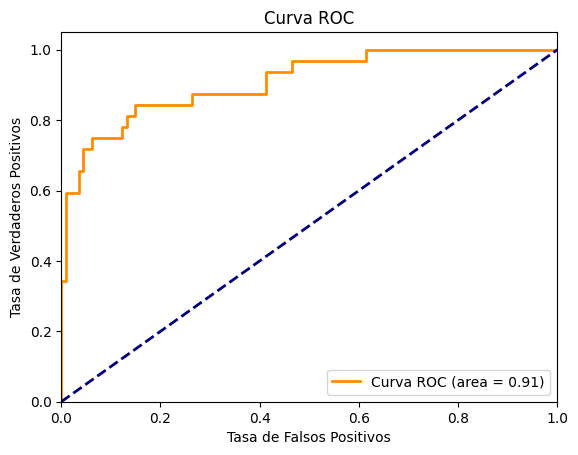

In [ ]:
# calcular las tasas de verdaderos y falsos positivos
fpr, tpr, _ = roc_curve(targets, preds.cpu()[:, 1])

# calcular el AUC
roc_auc = auc(fpr, tpr)

# crear la figura para el gráfico
plt.figure()

# dibujar la curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)

# dibujar la línea diagonal que representa un clasificador aleatorio
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# especificar los límites de los ejes x e y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# añadir etiquetas y un título
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

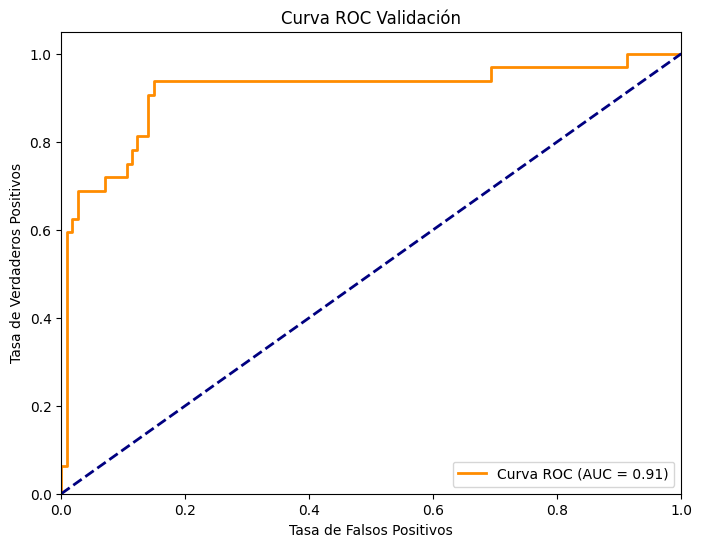

In [ ]:
# obtenemos las predicciones y etiquetas del conjunto de validacion
preds, targets = learn.get_preds(ds_idx=1)
predicted_probs = preds[:, 1]

# calculamos la curva ROC para el conjunto de validacion
fpr, tpr, _ = roc_curve(targets.cpu(), predicted_probs.cpu())
test_auc = auc(fpr, tpr)

# dibujamos la curva ROC en el conjunto de validacion
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Validación')
plt.legend(loc='lower right')
plt.show()

## Curva de calibracion

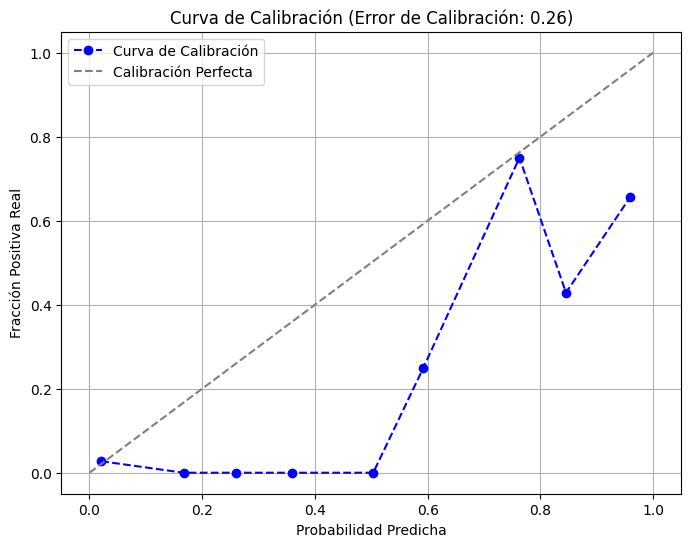

In [ ]:
# calculamos la curva de calibración para todas las probabilidades predichas y etiquetas verdaderas
y_pred_prob = preds[:, 1].cpu().numpy()
prob_true, prob_pred = calibration_curve(targets.cpu(), y_pred_prob, n_bins=9)

# calculamos el Error de Calibración
calibration_error = np.abs(prob_true - prob_pred).mean()

# dibujamos la curva de calibración junto con el Error de Calibración
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', color='blue', label='Curva de Calibración')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibración Perfecta')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Fracción Positiva Real')
plt.title(f'Curva de Calibración (Error de Calibración: {calibration_error:.2f})')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Curva de calibracion mejorada

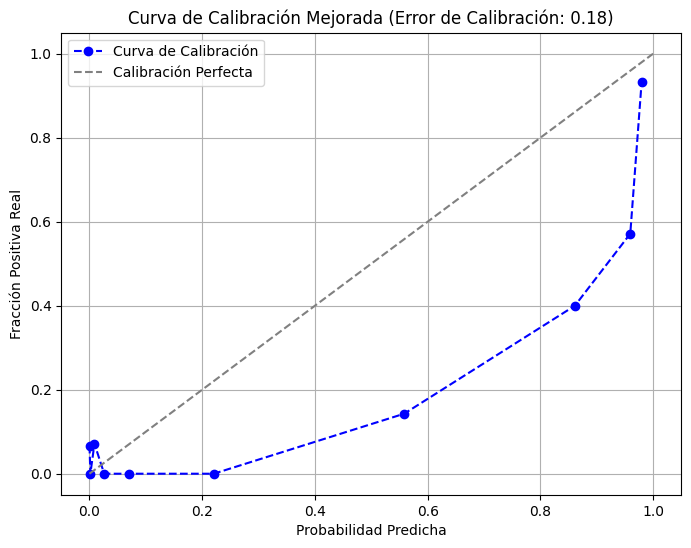

In [ ]:
# calculamos la curva de calibración con estrategia "quantile"
y_pred_prob = preds[:, 1].cpu().numpy()
prob_true, prob_pred = calibration_curve(targets.cpu(), y_pred_prob, n_bins=9, strategy='quantile')
#prob_true, prob_pred = calibration_curve(targets.cpu(), y_pred_prob, n_bins=10, strategy='uniform')

# Calculamos el Error de Calibración
calibration_error = np.abs(prob_true - prob_pred).mean()

# dibujamos la curva de calibración
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', color='blue', label='Curva de Calibración')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibración Perfecta')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Fracción Positiva Real')
plt.title(f'Curva de Calibración Mejorada (Error de Calibración: {calibration_error:.2f})')
plt.legend(loc='best')
plt.grid(True)
plt.show()

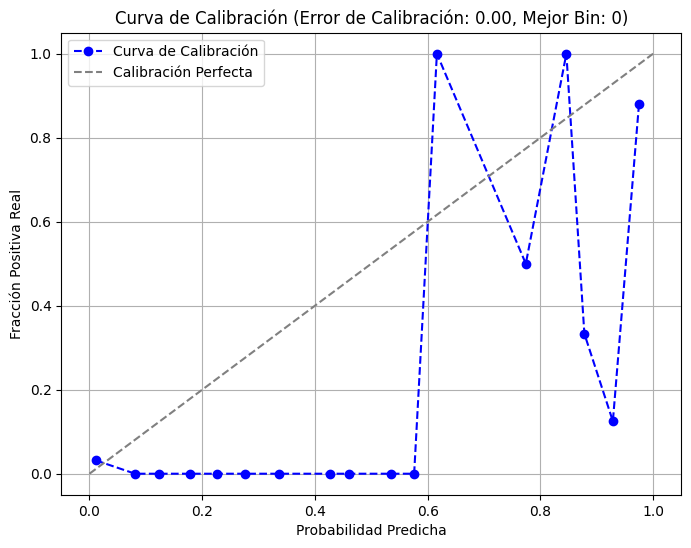

     Bin  Calibration Error
0    0.0           0.148602
1    1.0           0.148602
2    2.0           0.183268
3    3.0           0.248873
4    4.0           0.278865
5    5.0           0.253430
6    6.0           0.274786
7    7.0           0.283577
8    8.0           0.276435
9    9.0           0.263505
10  10.0           0.311237
11  11.0           0.300970
12  12.0           0.297575
13  13.0           0.310892
14  14.0           0.302247
15  15.0           0.313266
16  16.0           0.298280
17  17.0           0.310717
18  18.0           0.333322
19  19.0           0.329460
20  20.0           0.323206


In [ ]:
# Inicializa variables para guardar el mejor bin y el menor error de calibración
best_bin = 0
#min_calibration_error = float('inf')
min_calibration_error = 0

# Crear un DataFrame para almacenar los resultados
results_bins = pd.DataFrame(columns=['Bin', 'Calibration Error'])

# Bucle para probar diferentes bins
for n_bins in range(21):
    # Calcula la curva de calibración para el número actual de bins
    y_pred_prob = preds[:, 1].cpu().numpy()
    prob_true, prob_pred = calibration_curve(targets.cpu(), y_pred_prob, n_bins=n_bins)

    # Calcula el Error de Calibración
    calibration_error = np.abs(prob_true - prob_pred).mean()

    # Agrega los resultados a la tabla
    results_bins = results_bins.append({'Bin': n_bins, 'Calibration Error': calibration_error}, ignore_index=True)

    # Actualiza el bin y el error mínimo si es menor que el mínimo anterior
    if calibration_error < min_calibration_error:
        min_calibration_error = calibration_error
        best_bin = n_bins

# Vuelve a calcular la curva de calibración con el mejor bin
y_pred_prob = preds[:, 1].cpu().numpy()
prob_true, prob_pred = calibration_curve(targets.cpu(), y_pred_prob, n_bins=n_bins)

# Dibuja la curva de calibración con el mejor bin y el Error de Calibración mínimo
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', color='blue', label='Curva de Calibración')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibración Perfecta')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Fracción Positiva Real')
plt.title(f'Curva de Calibración (Error de Calibración: {min_calibration_error:.2f}, Mejor Bin: {best_bin})')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Imprime la tabla con los errores de calibración
print(results_bins)